In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/muef/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

### importing data

In [2]:
# import coal data
data_dir = 'data/'
bk = pd.read_csv(data_dir + 'Braunkohlefoerderung.csv', header=1, index_col=0)
sk = pd.read_csv(data_dir + 'Steinkohlefoerderung.csv', header=1, index_col=0)
si = pd.read_csv(data_dir + 'hard coal imports.csv', header=1, index_col=0)

coal_production = pd.merge(bk, sk, left_index=True, right_index=True, how='outer')
# convert from 1000 t to Mt
coal_production = coal_production / 1000
coal_production = pd.merge(coal_production, si, left_index=True, right_index=True, how='outer')

In [4]:
coal_production

,lignite production,hard coal production,hard coal import
year,,,
1950,212.890859,NaN,NaN
1951,234.373297,NaN,NaN
1952,241.826483,NaN,NaN
1953,257.305837,NaN,NaN
1954,269.725653,NaN,NaN
1955,290.949381,NaN,NaN
1956,301.100751,NaN,NaN
1957,309.406083,149.446,18.9
1958,308.457114,NaN,13.9


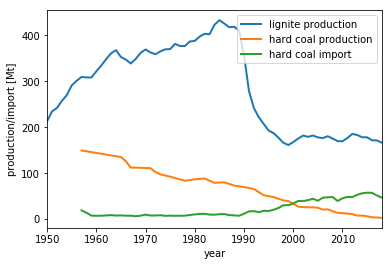

In [5]:
coal_production.interpolate().plot(linewidth=2)

plt.ylabel('production/import [Mt]')

In [6]:
# import classification

# map parliamentary periods to dates / years
topic_dir = "plots/topic_analysis_2155/"
topic_classification = pd.read_csv(topic_dir + '0_topic_list_2155_classification.csv', index_col=0)
topic_classification #['classification']

,label,top words,score pct,score,classification
178515,stop words,"darauf, darub, natur, richtig, tun, wiss, stel...",15.737580,619234.291928,procedural and general politics
178481,procedural 1,"bundeskanzl, red, deutsch, damal, sei, wirklic...",6.958758,273809.686006,procedural and general politics
178498,economic policy 1,"bundesregier, wirtschaft, wichtig, entwickl, h...",5.158223,202963.147750,economy and finance
178513,procedural 2,"gesetz, gesetzentwurf, bundestag, bundesregier...",3.622950,142553.991272,procedural and general politics
178495,europe,"europa, gemeinsam, deutschland, deutsch, staat...",3.593901,141410.998528,regional aspects
178489,procedural 3,"gesetz, wirtschaft, entwurf, bundesregier, bun...",3.068980,120756.670825,procedural and general politics
178497,general policy statements,"freiheit, staat, sozial, volk, gesellschaft, d...",2.963721,116614.982983,procedural and general politics
178478,German-French coal plan,"deutsch, franzos, frankreich, europa, deutschl...",2.946700,115945.235466,regional aspects
178484,budget,"million, mittel, haushalt, rund, bund, insgesa...",2.811943,110642.907628,economy and finance
178472,green opposition,"geld, okolog, endlich, regier, wirklich, statt...",2.589397,101886.271129,procedural and general politics


# show in plot:

- coal production
- governments (with color)
- number of seats per party?
- policy events
- topic aggregation

In [7]:
run_id = 2155

save_dir = "./plots/topic_analysis_{}".format(run_id)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))
topic_period_scores = dts.values('topic__title','topic__id', 'ut__document__parlperiod__n').annotate(score = Sum('score'))

{'n': 3934749.14997559}


In [8]:
df = pd.DataFrame.from_dict(topic_period_scores)
df["classification"] = df["topic__id"]
def id_to_class(idn):
    return topic_classification.loc[idn]['classification']
df["classification"] = df["classification"].apply(id_to_class)

dfagg = df.groupby(["classification","ut__document__parlperiod__n"]).sum().drop(columns=["topic__id"])

dfagg = dfagg.unstack().transpose().droplevel(0)
dfagg

classification,economy and finance,energy and environment,international,procedural and general politics,regional aspects
ut__document__parlperiod__n,,,,,
1,85008.123611,12378.652356,2880.850405,118457.290220,132329.333408
2,87139.491936,29055.771649,1059.046435,97321.809760,46707.580221
3,83743.295627,23208.152630,1660.562798,64043.546329,13873.042616
4,47683.359902,27263.153889,1082.192305,53982.438783,13358.055120
5,90218.954627,43769.383321,3292.586682,118756.534893,20006.240476
6,24144.569659,5335.915314,790.244421,29178.343937,3228.576669
7,49254.901509,38359.195813,8271.601293,79106.073758,6638.977627
8,57232.559234,71101.405862,12841.484666,102484.052237,12582.498001
9,46301.444251,26018.376481,7337.208286,68138.560353,10897.910630


In [33]:
party_color_map = {'spd': "#0088FF", 'cducsu': "#222222", 'fdp': "#FFED00",
                   'gruene': "#64A12D", 'linke': "#8C3473", 'spd': "#EB001F", 'dp': '#808080'}


In [35]:
gvmt = pd.read_csv(data_dir + 'List of German governments.csv', header=1)
gvmt

,parliamentary period,begin year,end year,Party 1,Party 2,Party 3,chancellor
0,1,1949,1953,cducsu,fdp,dp,Konrad Adenauer
1,2,1953,1957,cducsu,fdp,dp,Konrad Adenauer
2,3,1957,1961,cducsu,dp,NaN,Konrad Adenauer
3,4,1961,1963,cducsu,fdp,dp,Konrad Adenauer
4,4,1963,1965,cducsu,fdp,NaN,Ludwig Erhard
5,5,1965,1966,cducsu,fdp,NaN,Ludwig Erhard
6,5,1966,1969,cducsu,spd,NaN,Kurt Georg Kiesinger
7,6,1969,1972,spd,fdp,NaN,Willy Brandt
8,7,1972,1974,spd,fdp,NaN,Willy Brandt
9,7,1974,1976,spd,fdp,NaN,Helmut Schmidt


In [54]:
mid_years = np.array([1951. , 1955. , 1959. , 1963. , 1967, 1970.5,
                      1974  , 1978. , 1981.5 , 1985. , 1988.5, 1992. ,
                      1996. , 2000. , 2003.5, 2007. , 2011. , 2015. , 2018. ])

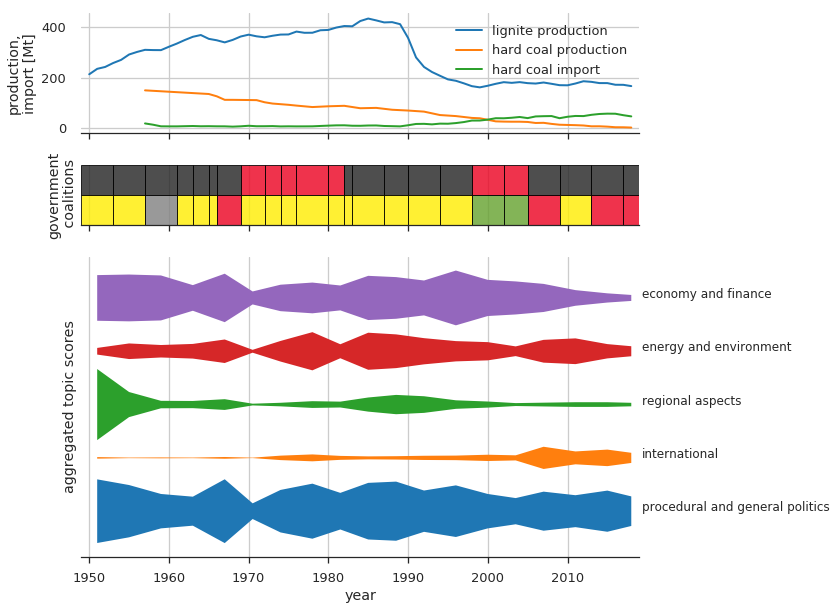

In [67]:
from matplotlib.patches import Rectangle

sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid':True,
               'axes.spines.left': False,
               'axes.spines.right': False,
               'axes.spines.top': False,
               'ytick.left': False})

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1, 5]})

# plot coal production

coal_production.interpolate().plot(linewidth=2, ax=ax[0])
ax[0].set_ylabel('production,\nimport [Mt]')

# plot government coalitions

for i in gvmt.index:
    width = gvmt.loc[i]['end year'] - gvmt.loc[i]['begin year']
    rect = Rectangle((gvmt.loc[i]['begin year'], 0.5), width, 0.5, alpha=0.8,
                     edgecolor='k', linewidth=1, facecolor = party_color_map[gvmt.loc[i]['Party 1']]) 
    ax[1].add_patch(rect)
    rect = Rectangle((gvmt.loc[i]['begin year'], 0), width, 0.5, alpha=0.8,
                     edgecolor='k', linewidth=1, facecolor = party_color_map[gvmt.loc[i]['Party 2']]) 
    ax[1].add_patch(rect)
    
ax[1].set_xlim([1949, 2019])
ax[1].set_yticks([])
ax[1].set_ylabel('government\n coalitions')

# plot aggregate topics

dfs = dfagg[["economy and finance", "energy and environment", "regional aspects",
             "international", "procedural and general politics"]]

ax[2].set_yticks([])

max_val = 1.5 * dfs.max().max()

for i, t in enumerate(reversed(dfs.columns)):
    ax[2].fill_between(mid_years, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
    ax[2].text(2019.3, (i+0.) *max_val, t, fontsize=12)

ax[2].set_xlabel('year')
ax[2].set_ylabel('aggregated topic scores')


plt.savefig(os.path.join(save_dir, 'topic_evolution_run{}_aggregate.png'.format(run_id)), dpi=150, bbox_inches="tight")

# compress folder to easily download it

In [ ]:
%%bash
zip -r plots/topic_analysis_2155.zip plots/topic_analysis_2155/